# FIG. 6. Impact of bridge losses in the Ahr valley: Analysis of change in commuter time.

In [1]:
# %%
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import osmnx as ox
import warnings
import networkx as nx

import seaborn as sns

from src import RoadNetwork as rn
from src import FloodModule as fm
from src import EffectiveVelocities as ev
from src import TrafficCentrality as tc
from src import SupportFunctions as sf

import cartopy.crs as ccrs
import matplotlib.lines as mlines

crs = ccrs.GOOGLE_MERCATOR
crs_proj4 = crs.proj4_init

fontsize = 30

pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots
    "font.sans-serif": [],  # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": fontsize,  # LaTeX default is 10pt font.
    "font.size": fontsize,
    "legend.fontsize": fontsize,  # Make the legend/label fonts
    "xtick.labelsize": fontsize,  # a little smaller
    "ytick.labelsize": fontsize,
    "figure.figsize": (16, 12),  # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join(
        [  # plots will use this preamble
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
            # r"\usepackage[detect-all,locale=DE]{siunitx}",
        ]
    ),
}

mpl.rcParams.update(pgf_with_latex)


### Creating RoadNetwork withing a bbox and removing all bridges from the graph, creating $G(V, E \backslash B)$.

In [2]:
west, east = 6.4, 7.9
south, north = 50.0, 51.2

driving_tags = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]
highway_filter = f"w/highway={','.join(driving_tags)}"

place = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=highway_filter,
    bbox=[north, south, west, east],
)
G = place.graph

place.loads("travel_time")

bridges = fm.flooded_bridges(G, fm.flood_footprint())
bridges["name"] = bridges["name"].combine_first(bridges["ref"])


num(nodes)= 23007
num(edges)= 47979
The SIBC has already been computed and stored. Providing the stored values.


/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


### Re-adding the bridges $k$ to $G(V, E \backslash B)$, and commputing the total commuter hour loss. The loads are precalculated, but the computation will still take approx. $\sim 15$ minutes, as the load rerouting takes some time.

In [3]:
warnings.filterwarnings("ignore")

gamma = 0.1 * 0.8
G = ev.effective_spillover_velocities(G, gamma)

lost_hours_arr = np.zeros(len(bridges["name"].astype("str").unique()))

for IDX in range(0, len(bridges["name"].astype("str").unique())):
    NAME = bridges["name"].astype("str").unique()[IDX]
    print(NAME)
    failed_bridge_idx = bridges[bridges["name"].astype(str) == NAME].index

    Gr = rn.remove_edges(G, bridges[~bridges.index.isin(failed_bridge_idx)].index)
    Gr = tc.interaction_betweenness_centrality(Gr, weight="travel_time", cpu_cores=5)

    Gr = ev.effective_spillover_velocities(Gr, gamma)
    edges, edges_r = ox.graph_to_gdfs(G, nodes=False), ox.graph_to_gdfs(Gr, nodes=False)

    edges_r["data"] = (
        (
            edges_r["spillover_travel_time"] * edges_r["spillover_load"]
            - edges["spillover_travel_time"] * edges["spillover_load"]
        )
        / 60
        / 60
    )
    lost_hours_arr[IDX] = sf.finite_sum(edges_r["data"])


B 266
The SIBC has already been computed and stored. Providing the stored values.
Rotweinstraße
The SIBC has already been computed and stored. Providing the stored values.
['Friedrichstraße', 'Ramersbacher Straße']
The SIBC has already been computed and stored. Providing the stored values.
L 83
The SIBC has already been computed and stored. Providing the stored values.
['Burgstraße', 'Königsfelder Straße', 'Neuenahrer Straße']
The SIBC has already been computed and stored. Providing the stored values.
Münstereifeler Straße
The SIBC has already been computed and stored. Providing the stored values.
['Bachemer Straße', 'Eifelstraße', 'Königstraße']
The SIBC has already been computed and stored. Providing the stored values.
B 258
The SIBC has already been computed and stored. Providing the stored values.
Landgrafenstraße
The SIBC has already been computed and stored. Providing the stored values.
['Josef-Emmerich-Straße', 'Liersbachtal', 'Talstraße', 'Ahrstraße']
The SIBC has already been 

### Computing the case where the B266 only has only half of its lanes for vehicle use.

In [4]:
b266 = bridges[bridges["name"].astype(str) == "B 266"]
b266_index = b266.index

Gr_halflanes = rn.remove_edges(G, bridges[~bridges.index.isin(b266_index)].index)

for u, v, k in b266_index:
    Gr_halflanes[u][v][k]["lanes"] = Gr_halflanes[u][v][k]["lanes"] / 2
    Gr_halflanes[u][v][k]["travel_time"] = Gr_halflanes[u][v][k]["travel_time"] + 0.1


Gr_halflanes = tc.interaction_betweenness_centrality(
    Gr_halflanes, weight="travel_time", cpu_cores=5, cache=True
)
Gr_halflanes = ev.effective_spillover_velocities(Gr_halflanes, gamma)

edges, edges_r = ox.graph_to_gdfs(G, nodes=False), ox.graph_to_gdfs(
    Gr_halflanes, nodes=False
)

edges_r["data"] = (
    (
        edges_r["spillover_travel_time"] * edges_r["spillover_load"]
        - edges["spillover_travel_time"] * edges["spillover_load"]
    )
    / 60
    / 60
)
lost_hours_arr = np.append(lost_hours_arr, sf.finite_sum(edges_r["data"]))


The SIBC has already been computed and stored. Providing the stored values.


### Compute the load+effective velocities for the null-case $G(V, E \backslash B)$, where all bridges are destroyed

In [5]:
Gr = rn.remove_edges(G, bridges.index)
Gr = tc.interaction_betweenness_centrality(Gr, weight="travel_time", cpu_cores=5)

Gr = ev.effective_spillover_velocities(Gr, gamma)
edges, edges_r = ox.graph_to_gdfs(G, nodes=False), ox.graph_to_gdfs(Gr, nodes=False)

edges_r["data"] = (
    (
        edges_r["spillover_travel_time"] * edges_r["spillover_load"]
        - edges["spillover_travel_time"] * edges["spillover_load"]
    )
    / 60
    / 60
)

lost_hours_arr = np.insert(lost_hours_arr, 0, sf.finite_sum(edges_r["data"]))


The SIBC has already been computed and stored. Providing the stored values.


### Compare every case to every other case and plot

Text(1426.6845453140131, 0.5, '$B \\backslash b_k$')

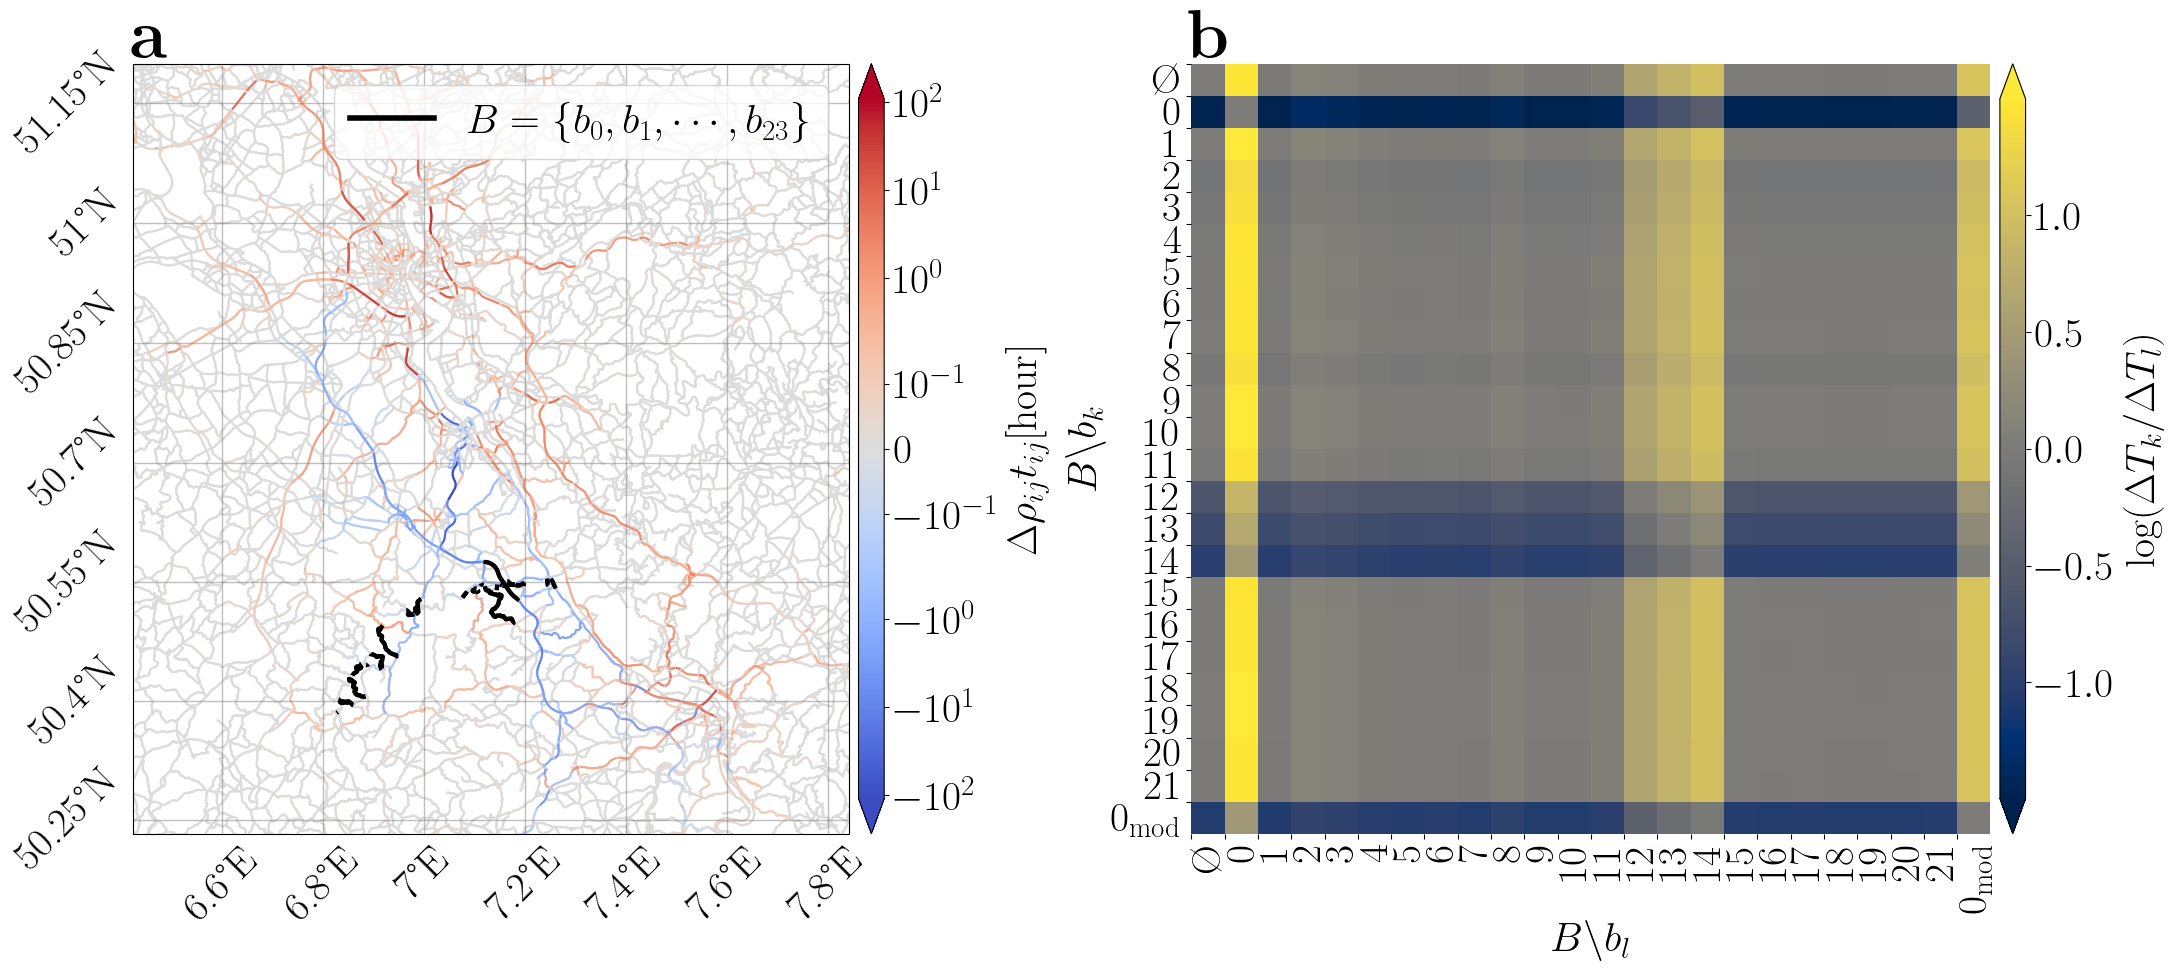

In [6]:
lost_hours_norm = lost_hours_arr / max(lost_hours_arr)

correlation_matrix = np.zeros((len(lost_hours_norm), (len(lost_hours_norm))))
for i in range(0, len(lost_hours_norm)):
    for j in range(0, len(lost_hours_norm)):
        correlation_matrix[i, j] = np.log(lost_hours_norm[i] / lost_hours_norm[j])


#######################

fig = plt.figure(figsize=(27, 10))
ax0 = fig.add_subplot(1, 2, 1, projection=crs)
ax0.text(
    0.05,
    1.07,
    r"\textbf{a}",
    transform=ax0.transAxes,
    fontweight="bold",
    fontsize=50,
    va="top",
    ha="right",
)


edges_r["absdata"] = np.abs(edges_r["data"])

linthresh = 0.15e0
vmin = min(edges_r["data"])
vmax = max(np.abs(edges_r[np.isfinite(edges_r["data"])]["data"]))

xmin, ymin, xmax, ymax = edges[np.abs(edges_r["data"]) > linthresh].unary_union.bounds

norm = mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("coolwarm")


# gpd.GeoSeries(fm.flood_footprint()).set_crs(region.edges.crs).to_crs(crs_proj4).plot(ax=ax, color='deepskyblue', zorder=3, hatch='\\\\', alpha=0.5, edgecolor="black")
edges_r[(edges_r["removed"] == True)].to_crs(crs_proj4).plot(
    ax=ax0, color="black", linewidth=3, zorder=3
)
edges_r.sort_values(by="absdata", ascending=True).to_crs(crs_proj4).plot(
    ax=ax0, column="data", cmap=cmap, norm=norm
)

scalar_mapper_b = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(scalar_mapper_b, ax=ax0, extend="both", pad=0.01, aspect=30)
cbar.ax.set_ylabel(r"$\Delta \rho_{i j}t_{i j} [\mathrm{hour}]$")

ax0.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
gl = ax0.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels={"bottom": "x", "left": "y"},
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="-",
)

gl.xlabel_style = {"rotation": 45}
gl.ylabel_style = {"rotation": 45}

failed = mlines.Line2D(
    [], [], color="black", label=r"$B = \{ b_0, b_1, \cdots, b_{23} \}$", linewidth=4
)

ax0.legend(handles=[failed], loc="upper right")


###########################
ax = fig.add_subplot(1, 2, 2)
ax.text(
    0.05,
    1.07,
    r"\textbf{b}",
    transform=ax.transAxes,
    fontweight="bold",
    fontsize=50,
    va="top",
    ha="right",
)
cmap = mpl.cm.cividis
norm = mpl.colors.Normalize(
    vmin=np.min(correlation_matrix), vmax=np.max(correlation_matrix)
)

# mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, ax=ax, cmap=cmap, cbar=False)  # , mask=mask)

scalar_mapper_b = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(scalar_mapper_b, ax=ax, extend="both", pad=0.01, aspect=30)
cbar.ax.set_ylabel(r"log($\Delta T_k / \Delta T_l$)")

tick_labels = np.array(range(0, len(lost_hours_norm) - 2)).astype(str)
# tick_labels = [str(v) for v in tick_labels]
tick_labels = np.insert(tick_labels, 0, r"$\O$")
tick_labels = np.append(tick_labels, r"$0_\mathrm{mod}$")

ax.set_xticks(range(0, len(lost_hours_norm)), tick_labels, ha="left", rotation=90)
ax.set_yticks(range(0, len(lost_hours_norm)), tick_labels, va="top", rotation=0)

ax.set_xlabel(r"$B \backslash b_l$")
ax.set_ylabel(r"$B \backslash b_k$")


In [7]:
fig.savefig("results/figs/FIG6-Ahr-bridges.pdf", bbox_inches="tight")